# CNN Model

This notebook contains the construction and the evaluations of CNN models for colorization purposes.

In [15]:
import torch
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
from tqdm import tqdm
import torch.optim as optim
import torch.nn.functional as F
from utils.dataset import CocoDataset
from utils.plots import plot_l, reconstruct_lab, plot_model_pred
from utils.models import CNN, save_model, load_model

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Data import

In [3]:
height, width = 256, 256

transform = transforms.Compose([
    transforms.Resize((height, width)),
    transforms.ToTensor(), # tensorization brings image in range [0,1] and space CxHxW
])

In [4]:
path_sandro = "coco/images/train2014"
path_diego = "C:/Users/diego/coco/images/train2014/train2014"
dataset = CocoDataset(root=path_sandro, transform=transform)

Found 82783 images.


## Data preparation

We split our dataset in train and test data.

In [5]:
torch.manual_seed(42)
test_size = int(0.2 * len(dataset))
train_size = len(dataset) - test_size
train, test = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train, batch_size=64, shuffle=True)
test_loader = DataLoader(test, batch_size=64, shuffle=False)
train_size = 5000
small_train, _ = random_split(train, [train_size, len(train) - train_size])
small_train_loader = DataLoader(small_train, batch_size=64, shuffle=True)
test_size = 1000
small_test, _ = random_split(test, [test_size, len(test) - test_size])
small_test_loader = DataLoader(small_test, batch_size=64, shuffle=False)

## CNN Model

In [6]:
NUM_EPOCHS = 10

In [7]:
def plot_losses(train_losses, test_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train')
    plt.plot(test_losses, label='Test')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(linestyle = "--")
    plt.legend()
    plt.show()

In [35]:
def train_cnn(epochs, model, criterion, optimizer, train_loader, test_loader, device, save = False, save_name = ""):
    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        running_loss = 0.0
        test_loss = 0.0

        model.train()
        for _, l_channels, _, _, ab_channels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{NUM_EPOCHS}', leave=True):
            l_channels, ab_channels = l_channels.to(device), ab_channels.to(device)

            optimizer.zero_grad()
            outputs = model(l_channels)
            loss = criterion(outputs, ab_channels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))

        model.eval()
        with torch.no_grad():
            for _, l_channels, _, _, ab_channels in tqdm(test_loader, desc='Testing', leave=True):
                l_channels, ab_channels = l_channels.to(device), ab_channels.to(device)
                outputs = model(l_channels)
                loss = criterion(outputs, ab_channels)
                test_loss += loss.item()

        test_losses.append(test_loss / len(test_loader))

        print(f"Epoch {epoch + 1}, Train Loss: {train_losses[-1]}, Validation Loss: {test_losses[-1]}")
        
        if save and (epochs > 10):
            if epoch in [int(epochs / 3) - 1, 2 * int(epochs / 3) - 1, epochs - 1]: # save three checkpoints
                save_model(model, f"{save_name}_{epoch + 1}")

    print('Finished Training')
    return train_losses, test_losses

### MSE Loss

In [36]:
torch.manual_seed(42)
model = CNN(height, width).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.999))
criterion1 = nn.MSELoss()

In [37]:
torch.manual_seed(42)
train_losses, test_losses = train_cnn(NUM_EPOCHS, model, criterion1, optimizer, small_train_loader, small_test_loader, device)

Testing: 100%|██████████| 16/16 [00:22<00:00,  1.43s/it]


Epoch 1, Train Loss: 0.25047509447683264, Validation Loss: 0.1860896572470665


Testing: 100%|██████████| 16/16 [00:21<00:00,  1.32s/it]


Epoch 2, Train Loss: 0.11827776727231243, Validation Loss: 0.06153316143900156


Testing: 100%|██████████| 16/16 [00:21<00:00,  1.33s/it]


Epoch 3, Train Loss: 0.03350061601428669, Validation Loss: 0.015391862893011421


Testing: 100%|██████████| 16/16 [00:21<00:00,  1.34s/it]


Epoch 4, Train Loss: 0.0092760074376777, Validation Loss: 0.005874306050827727


Testing: 100%|██████████| 16/16 [00:21<00:00,  1.34s/it]


Epoch 5, Train Loss: 0.004450206821666488, Validation Loss: 0.003934786858735606


Testing: 100%|██████████| 16/16 [00:21<00:00,  1.33s/it]


Epoch 6, Train Loss: 0.0034360448134284987, Validation Loss: 0.0035249754146207124


Testing: 100%|██████████| 16/16 [00:24<00:00,  1.52s/it]


Epoch 7, Train Loss: 0.0031889240446064293, Validation Loss: 0.0034322596475249156


Testing: 100%|██████████| 16/16 [00:21<00:00,  1.32s/it]


Epoch 8, Train Loss: 0.0031170369850919595, Validation Loss: 0.0033905594027601182


Testing: 100%|██████████| 16/16 [00:21<00:00,  1.36s/it]


Epoch 9, Train Loss: 0.0030883000102601473, Validation Loss: 0.003396754211280495


Testing: 100%|██████████| 16/16 [00:23<00:00,  1.44s/it]

Epoch 10, Train Loss: 0.003046417594121038, Validation Loss: 0.003402121248655021
Finished Training


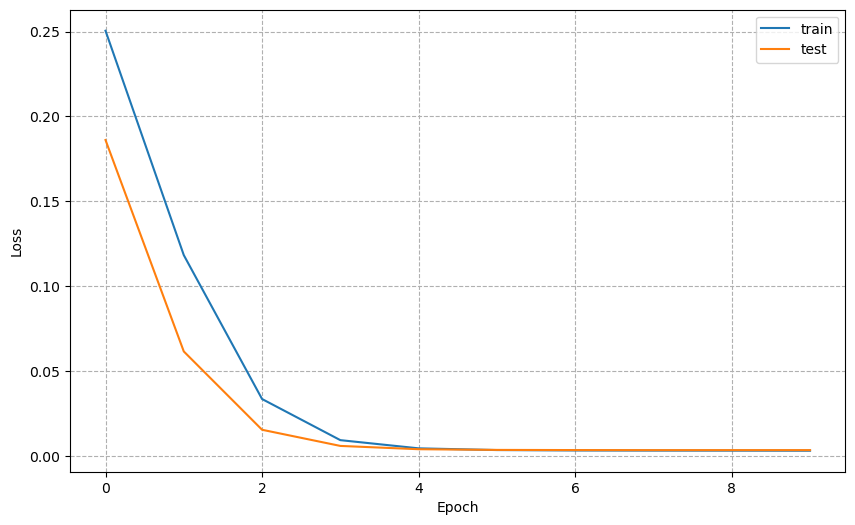

In [38]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(linestyle = "--")
plt.legend()
plt.show()

In [51]:
save_model(model, "CNN_MSELoss")

Model saved to models\CNN_MSELoss.pth successfully!


In [8]:
loaded_model1 = load_model(CNN(height, width), "models/CNN_MSELoss.pth").to(device)

CNN model loaded successfully!


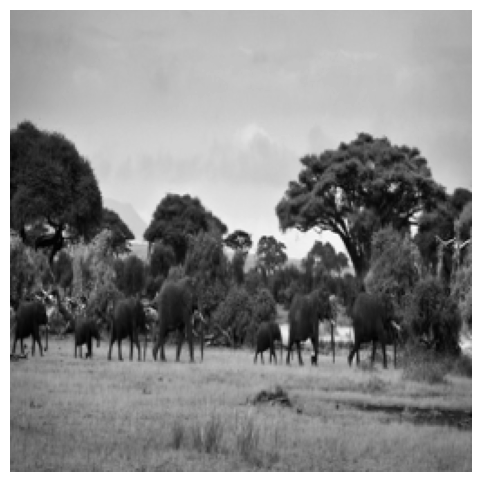

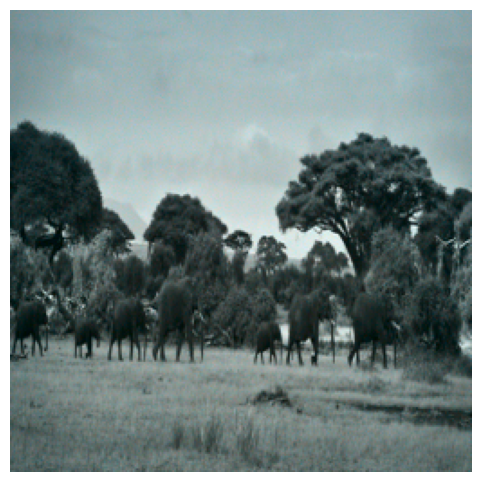

In [17]:
plot_l(dataset[76][1])
plot_model_pred(dataset[76][1], loaded_model1, device)

In [14]:
torch.manual_seed(42)
loaded_model1.eval()

total_mse = 0
total_psnr = 0
num_samples = 0

with torch.no_grad():
    for _, l_channels, _, _, ab_channels in small_test_loader:
        l_channels = l_channels.to(device)
        ab_channels = ab_channels.to(device)

        ab_preds = loaded_model1(l_channels)

        mse = F.mse_loss(ab_preds, ab_channels)
        total_mse += mse.item() * ab_channels.size(0)

        max_pixel_value = 1.0  # image values are between 0 and 1
        psnr = 20 * torch.log10(max_pixel_value**2 / mse)
        total_psnr += psnr.item() * ab_channels.size(0)

        num_samples += ab_channels.size(0)

avg_mse = total_mse / num_samples
avg_psnr = total_psnr / num_samples

print(f"Average MSE: {avg_mse:.4f}")
print(f"Average PSNR: {avg_psnr:.4f}")

Average MSE: 0.0040
Average PSNR: 48.0425


### L1 Loss

In [51]:
torch.manual_seed(42)
model = CNN(height, width).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.999))

In [52]:
torch.manual_seed(42)
train_losses = []
test_losses = []
criterion2 = nn.L1Loss()

for epoch in range(NUM_EPOCHS):
    running_loss = 0.0
    test_loss = 0.0

    # Training loop
    model.train()
    for _, l_channels, _, _, ab_channels in tqdm(small_train_loader, desc=f'Epoch {epoch + 1}/{NUM_EPOCHS}', leave=True):
        l_channels, ab_channels = l_channels.to(device), ab_channels.to(device)

        optimizer.zero_grad()
        outputs = model(l_channels)
        loss = criterion2(outputs, ab_channels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # scheduler.step()  # Update the scheduler
    train_losses.append(running_loss / len(train_loader))

    # Testing loop
    model.eval()
    with torch.no_grad():
        for _, l_channels, _, _, ab_channels in tqdm(small_test_loader, desc='Testing', leave=True):
            l_channels, ab_channels = l_channels.to(device), ab_channels.to(device)
            outputs = model(l_channels)
            loss = criterion2(outputs, ab_channels)
            test_loss += loss.item()

    test_losses.append(test_loss / len(test_loader))

    # Print training and validation losses
    print(f"Epoch {epoch + 1}, Train Loss: {train_losses[-1]}, Validation Loss: {test_losses[-1]}")

print('Finished Training')

Testing: 100%|██████████| 16/16 [00:05<00:00,  3.03it/s]


Epoch 1, Train Loss: 0.010877818005960344, Validation Loss: 0.0028675440626945276


Testing: 100%|██████████| 16/16 [00:05<00:00,  2.89it/s]


Epoch 2, Train Loss: 0.0031171747703771084, Validation Loss: 0.002579914902167891


Testing: 100%|██████████| 16/16 [00:05<00:00,  2.95it/s]


Epoch 3, Train Loss: 0.002982604723189764, Validation Loss: 0.002515477203839534


Testing: 100%|██████████| 16/16 [00:05<00:00,  3.12it/s]


Epoch 4, Train Loss: 0.0029455114713901483, Validation Loss: 0.0025518674072611746


Testing: 100%|██████████| 16/16 [00:05<00:00,  3.13it/s]


Epoch 5, Train Loss: 0.002943876090545009, Validation Loss: 0.002615086777444972


Testing: 100%|██████████| 16/16 [00:05<00:00,  3.12it/s]


Epoch 6, Train Loss: 0.0029147215943405593, Validation Loss: 0.002476086012990318


Testing: 100%|██████████| 16/16 [00:05<00:00,  3.14it/s]


Epoch 7, Train Loss: 0.0028924064377799704, Validation Loss: 0.00241786939124343


Testing: 100%|██████████| 16/16 [00:05<00:00,  3.13it/s]


Epoch 8, Train Loss: 0.002905570834443189, Validation Loss: 0.0024565720218719203


Testing: 100%|██████████| 16/16 [00:05<00:00,  3.10it/s]


Epoch 9, Train Loss: 0.0028750261822760395, Validation Loss: 0.0024101923446397523


Testing: 100%|██████████| 16/16 [00:05<00:00,  3.15it/s]


Epoch 10, Train Loss: 0.002876082010531195, Validation Loss: 0.0024381203569730737


Testing: 100%|██████████| 16/16 [00:05<00:00,  3.14it/s]


Epoch 11, Train Loss: 0.002874705728125457, Validation Loss: 0.002368933014197699


Testing: 100%|██████████| 16/16 [00:05<00:00,  3.12it/s]


Epoch 12, Train Loss: 0.0028611226862179486, Validation Loss: 0.0023850915543591196


Testing: 100%|██████████| 16/16 [00:05<00:00,  3.10it/s]


Epoch 13, Train Loss: 0.0028361484912282605, Validation Loss: 0.0024152678441126834


Testing: 100%|██████████| 16/16 [00:05<00:00,  3.14it/s]


Epoch 14, Train Loss: 0.0028430810711090114, Validation Loss: 0.0023736026152450605


Testing: 100%|██████████| 16/16 [00:05<00:00,  3.13it/s]

Epoch 15, Train Loss: 0.00283956340185686, Validation Loss: 0.00241447172512419
Finished Training


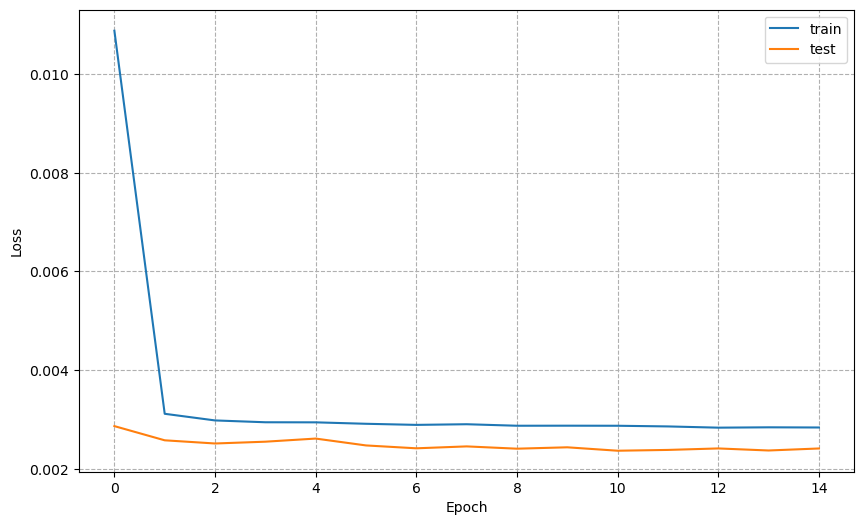

In [53]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(linestyle = "--")
plt.legend()
plt.show()

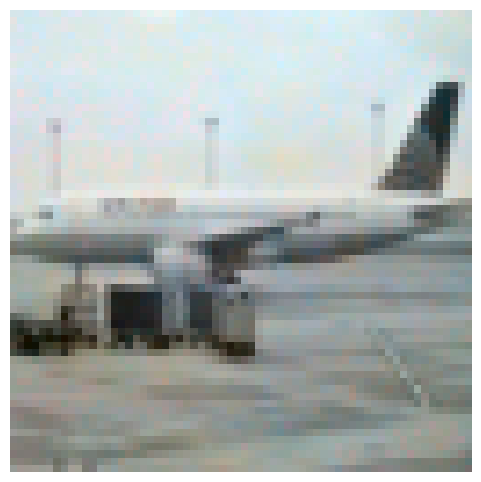

In [54]:
input = dataset[7653][1].to(device).unsqueeze(0)
ab = model(input).squeeze(0)
reconstruct_lab(dataset[7653][1].to(device).detach().cpu(), ab.detach().cpu())

In [55]:
save_model(model, "CNN_L1Loss")

Model saved to models\CNN_L1Loss.pth successfully!


In [56]:
loaded_model2 = load_model(CNN(height, width), "models/CNN_L1Loss.pth").to(device)

CNN model loaded successfully!


In [57]:
torch.manual_seed(42)
loaded_model2.eval()

total_mse = 0
total_psnr = 0
num_samples = 0

with torch.no_grad():
    for _, l_channels, _, _, ab_channels in small_test_loader:
        l_channels = l_channels.to(device)
        ab_channels = ab_channels.to(device)

        ab_preds = loaded_model2(l_channels)

        mse = F.mse_loss(ab_preds, ab_channels)
        total_mse += mse.item() * ab_channels.size(0)

        max_pixel_value = 1.0  # image values are between 0 and 1
        psnr = 20 * torch.log10(max_pixel_value**2 / mse)
        total_psnr += psnr.item() * ab_channels.size(0)

        num_samples += ab_channels.size(0)

avg_mse = total_mse / num_samples
avg_psnr = total_psnr / num_samples

print(f"Average MSE: {avg_mse:.4f}")
print(f"Average PSNR: {avg_psnr:.4f}")

Average MSE: 0.0033
Average PSNR: 49.6637


### Smooth L1 loss

In [58]:
torch.manual_seed(42)

model = CNN(height, width).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.999))

In [59]:
torch.manual_seed(42)
train_losses = []
test_losses = []
criterion3 = nn.SmoothL1Loss()

for epoch in range(NUM_EPOCHS):
    running_loss = 0.0
    test_loss = 0.0

    # Training loop
    model.train()
    for _, l_channels, _, _, ab_channels in tqdm(small_train_loader, desc=f'Epoch {epoch + 1}/{NUM_EPOCHS}', leave=True):
        l_channels, ab_channels = l_channels.to(device), ab_channels.to(device)

        optimizer.zero_grad()
        outputs = model(l_channels)
        loss = criterion3(outputs, ab_channels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # scheduler.step()  # Update the scheduler
    train_losses.append(running_loss / len(train_loader))

    # Testing loop
    model.eval()
    with torch.no_grad():
        for _, l_channels, _, _, ab_channels in tqdm(small_test_loader, desc='Testing', leave=True):
            l_channels, ab_channels = l_channels.to(device), ab_channels.to(device)
            outputs = model(l_channels)
            loss = criterion3(outputs, ab_channels)
            test_loss += loss.item()

    test_losses.append(test_loss / len(test_loader))

    # Print training and validation losses
    print(f"Epoch {epoch + 1}, Train Loss: {train_losses[-1]}, Validation Loss: {test_losses[-1]}")

print('Finished Training')

Testing: 100%|██████████| 16/16 [00:05<00:00,  3.11it/s]


Epoch 1, Train Loss: 0.002830648135083417, Validation Loss: 0.0001388896071499494


Testing: 100%|██████████| 16/16 [00:05<00:00,  3.15it/s]


Epoch 2, Train Loss: 0.0001483574387019023, Validation Loss: 0.00011229651492865734


Testing: 100%|██████████| 16/16 [00:05<00:00,  3.12it/s]


Epoch 3, Train Loss: 0.00013277501391993773, Validation Loss: 0.00010430103691086231


Testing: 100%|██████████| 16/16 [00:05<00:00,  3.11it/s]


Epoch 4, Train Loss: 0.00012539389828930875, Validation Loss: 0.00010300368838314269


Testing: 100%|██████████| 16/16 [00:05<00:00,  3.18it/s]


Epoch 5, Train Loss: 0.0001240088522281264, Validation Loss: 0.000105739789151921


Testing: 100%|██████████| 16/16 [00:05<00:00,  3.08it/s]


Epoch 6, Train Loss: 0.0001221459370178445, Validation Loss: 0.00010420696209382596


Testing: 100%|██████████| 16/16 [00:05<00:00,  3.10it/s]


Epoch 7, Train Loss: 0.00012260266716911453, Validation Loss: 0.00010123214474070141


Testing: 100%|██████████| 16/16 [00:05<00:00,  3.12it/s]


Epoch 8, Train Loss: 0.00012201366952849903, Validation Loss: 0.00010319653193692903


Testing: 100%|██████████| 16/16 [00:05<00:00,  3.15it/s]


Epoch 9, Train Loss: 0.00012050736346844458, Validation Loss: 9.871723578027432e-05


Testing: 100%|██████████| 16/16 [00:05<00:00,  3.13it/s]


Epoch 10, Train Loss: 0.00011873860474549918, Validation Loss: 0.00010221156841827175


Testing: 100%|██████████| 16/16 [00:05<00:00,  3.01it/s]


Epoch 11, Train Loss: 0.00011936200901883956, Validation Loss: 9.948101558122051e-05


Testing: 100%|██████████| 16/16 [00:05<00:00,  3.10it/s]


Epoch 12, Train Loss: 0.000119139580393507, Validation Loss: 9.758844180571987e-05


Testing: 100%|██████████| 16/16 [00:05<00:00,  3.14it/s]


Epoch 13, Train Loss: 0.00011762718294391741, Validation Loss: 9.807834444876803e-05


Testing: 100%|██████████| 16/16 [00:05<00:00,  3.15it/s]


Epoch 14, Train Loss: 0.00011730479517420709, Validation Loss: 0.00010589170395522504


Testing: 100%|██████████| 16/16 [00:05<00:00,  3.15it/s]

Epoch 15, Train Loss: 0.00011730464647753515, Validation Loss: 9.980120985592539e-05
Finished Training


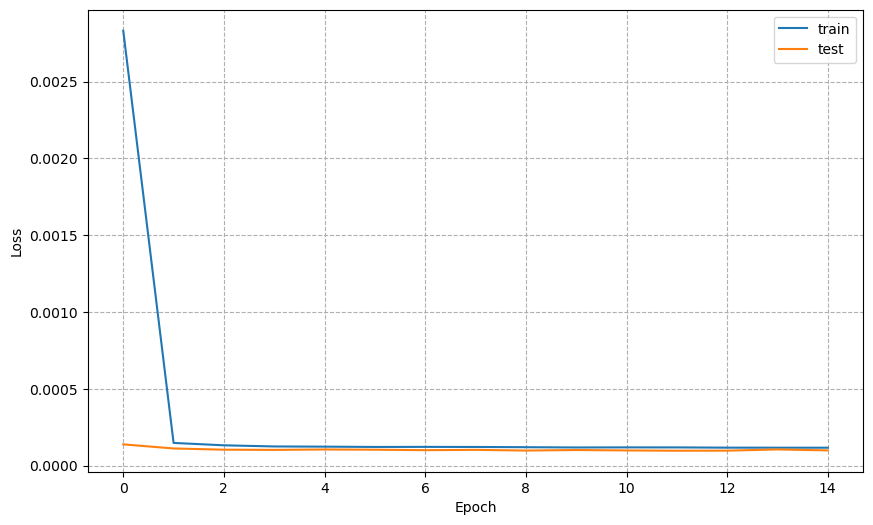

In [60]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(linestyle = "--")
plt.legend()
plt.show()

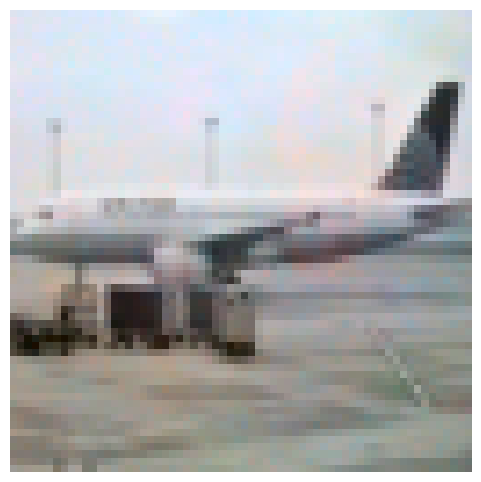

In [61]:
input = dataset[7653][1].to(device).unsqueeze(0)
ab = model(input).squeeze(0)
reconstruct_lab(dataset[7653][1].to(device).detach().cpu(), ab.detach().cpu())

In [62]:
save_model(model, "CNN_SmoothL1")

Model saved to models\CNN_SmoothL1.pth successfully!


In [63]:
loaded_model3 = load_model(CNN(height, width), "models/CNN_SmoothL1.pth").to(device)

CNN model loaded successfully!


In [64]:
torch.manual_seed(42)
loaded_model3.eval()

total_mse = 0
total_psnr = 0
num_samples = 0

with torch.no_grad():
    for _, l_channels, _, _, ab_channels in small_test_loader:
        l_channels = l_channels.to(device)
        ab_channels = ab_channels.to(device)

        ab_preds = loaded_model3(l_channels)

        mse = F.mse_loss(ab_preds, ab_channels)
        total_mse += mse.item() * ab_channels.size(0)

        max_pixel_value = 1.0  # image values are between 0 and 1
        psnr = 20 * torch.log10(max_pixel_value**2 / mse)
        total_psnr += psnr.item() * ab_channels.size(0)

        num_samples += ab_channels.size(0)

avg_mse = total_mse / num_samples
avg_psnr = total_psnr / num_samples

print(f"Average MSE: {avg_mse:.4f}")
print(f"Average PSNR: {avg_psnr:.4f}")

Average MSE: 0.0032
Average PSNR: 49.8480
